In [1]:
library(CellChat)
library(patchwork)
library(Seurat)
options(stringsAsFactors = FALSE)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Attaching SeuratObject



In [2]:
readRDS('RDS/CZI_processed.rds')->rna

In [11]:
data.input <- rna[["RNA"]]@data # normalized data matrix
# For Seurat version >= “5.0.0”, get the normalized data via `seurat_object[["RNA"]]$data`
labels <- rna$celltype2
meta <- data.frame(labels = labels, row.names = names(labels)) # create a dataframe of the cell labels

In [12]:
cellchat <- createCellChat(object = rna, group.by = "celltype2", assay = "RNA")

[1] "Create a CellChat object from a Seurat object"
The `meta.data` slot in the Seurat object is used as cell meta information 


Warning message in createCellChat(object = rna, group.by = "celltype2", assay = "RNA"):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Endothelial1, Endothelial2, Fibroblast, Lymphocyte, Microvasculature, Smooth Muscle, Macrophage 


In [13]:
cellchat <- addMeta(cellchat, meta = meta)
cellchat <- setIdent(cellchat, ident.use = "labels") # set "labels" as default cell identity
levels(cellchat@idents) # show factor levels of the cell labels
groupSize <- as.numeric(table(cellchat@idents)) # number of cells in each cell group

[1] "Endothelial1"     "Endothelial2"     "Fibroblast"       "Lymphocyte"      
[5] "Microvasculature" "Smooth Muscle"    "Macrophage"

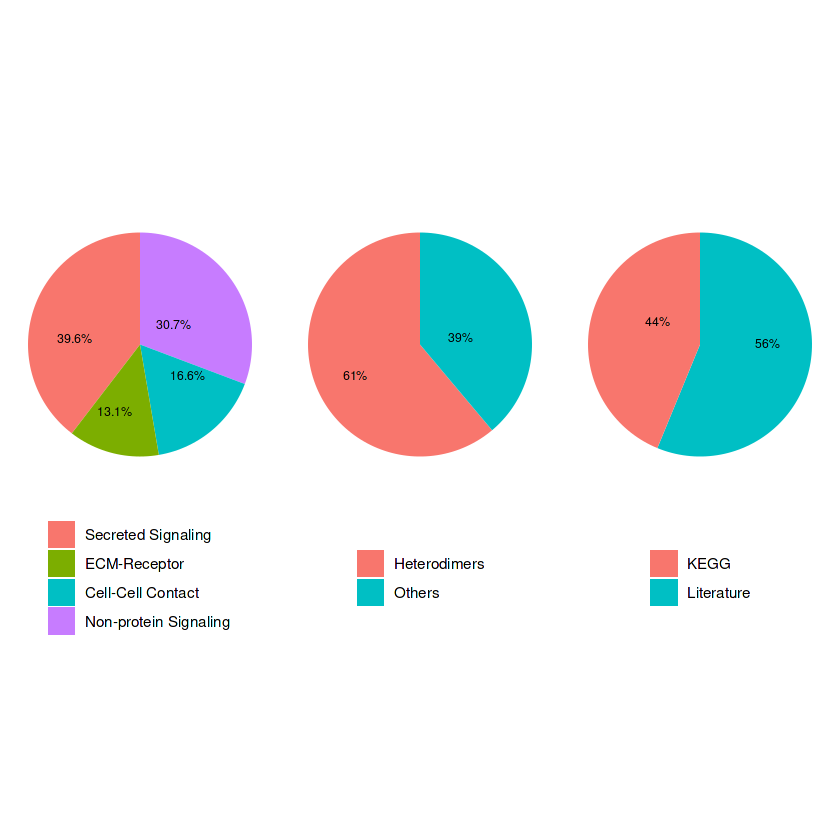

In [14]:
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)

In [15]:
# use a subset of CellChatDB for cell-cell communication analysis
#CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") # use Secreted Signaling

# Only uses the Secreted Signaling from CellChatDB v1
#  CellChatDB.use <- subsetDB(CellChatDB, search = list(c("Secreted Signaling"), c("CellChatDB v1")), key = c("annotation", "version"))

# use all CellChatDB except for "Non-protein Signaling" for cell-cell communication analysis
CellChatDB.use <- subsetDB(CellChatDB)


# use all CellChatDB for cell-cell communication analysis
# CellChatDB.use <- CellChatDB # simply use the default CellChatDB. We do not suggest to use it in this way because CellChatDB v2 includes "Non-protein Signaling" (i.e., metabolic and synaptic signaling). 

# set the used database in the object
cellchat@DB <- CellChatDB.use

In [16]:
# subset the expression data of signaling genes for saving computation cost
cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) # do parallel
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

The number of highly variable ligand-receptor pairs used for signaling inference is 1801 


In [17]:
# project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
# This function is useful when analyzing single-cell data with shallow sequencing depth because the projection 
# reduces the dropout effects of signaling genes, in particular for possible zero expression of subunits of 
# ligands/receptors. One might be concerned about the possible artifact introduced by this diffusion process, 
# however, it will only introduce very weak communications. 
# By default CellChat uses the raw data (i.e., object@data.signaling) instead of the projected data. 
# To use the projected data, users should run the function projectData before running computeCommunProb, 
# and then set raw.use = FALSE when running computeCommunProb.

#cellchat <- projectData(cellchat, PPI.human)

In [18]:
options(future.globals.maxSize = 8000 * 1024^2)
cellchat <- computeCommunProb(cellchat, type = "triMean")

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-05-01 11:33:21.028827]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-05-01 12:07:17.185496]"


In [19]:
cellchat <- filterCommunication(cellchat, min.cells = 10)

In [20]:
cellchat <- computeCommunProbPathway(cellchat)

In [21]:
cellchat <- aggregateNet(cellchat)

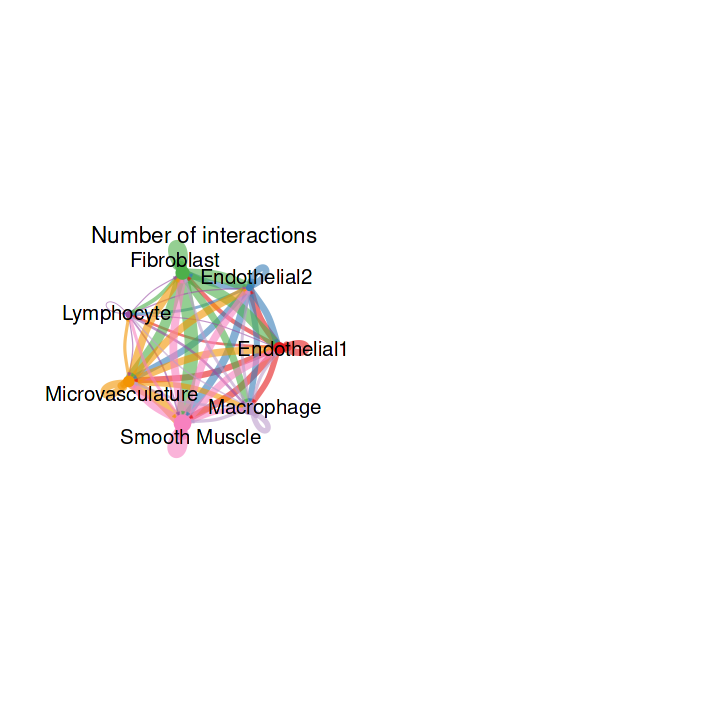

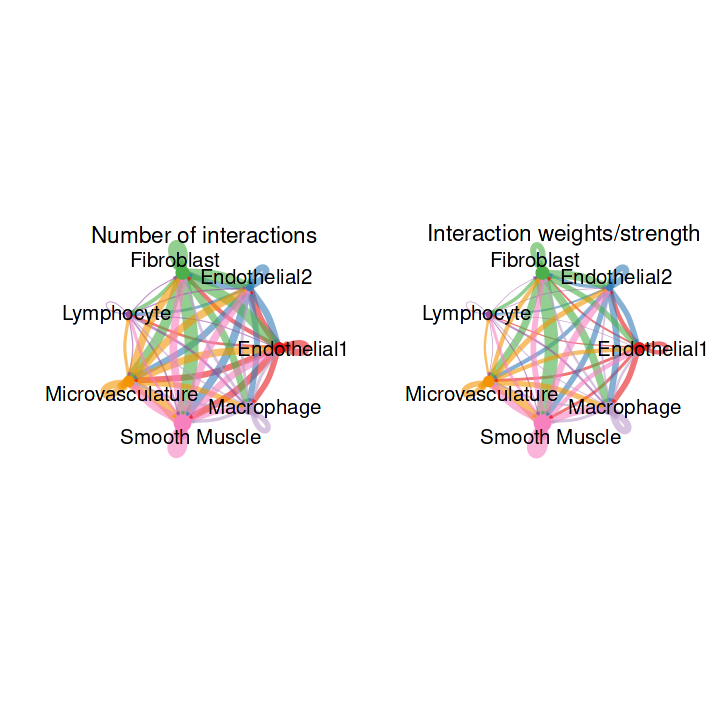

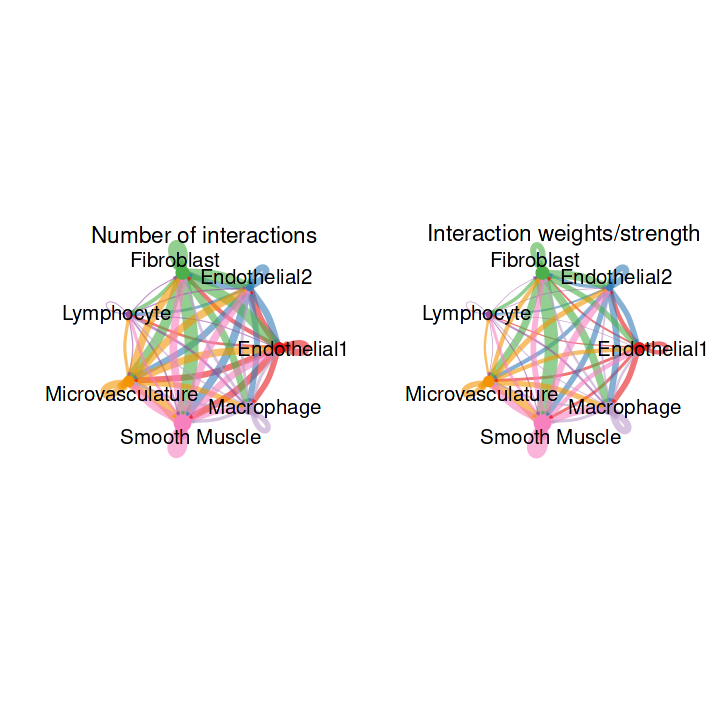

In [22]:
groupSize <- as.numeric(table(cellchat@idents))
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

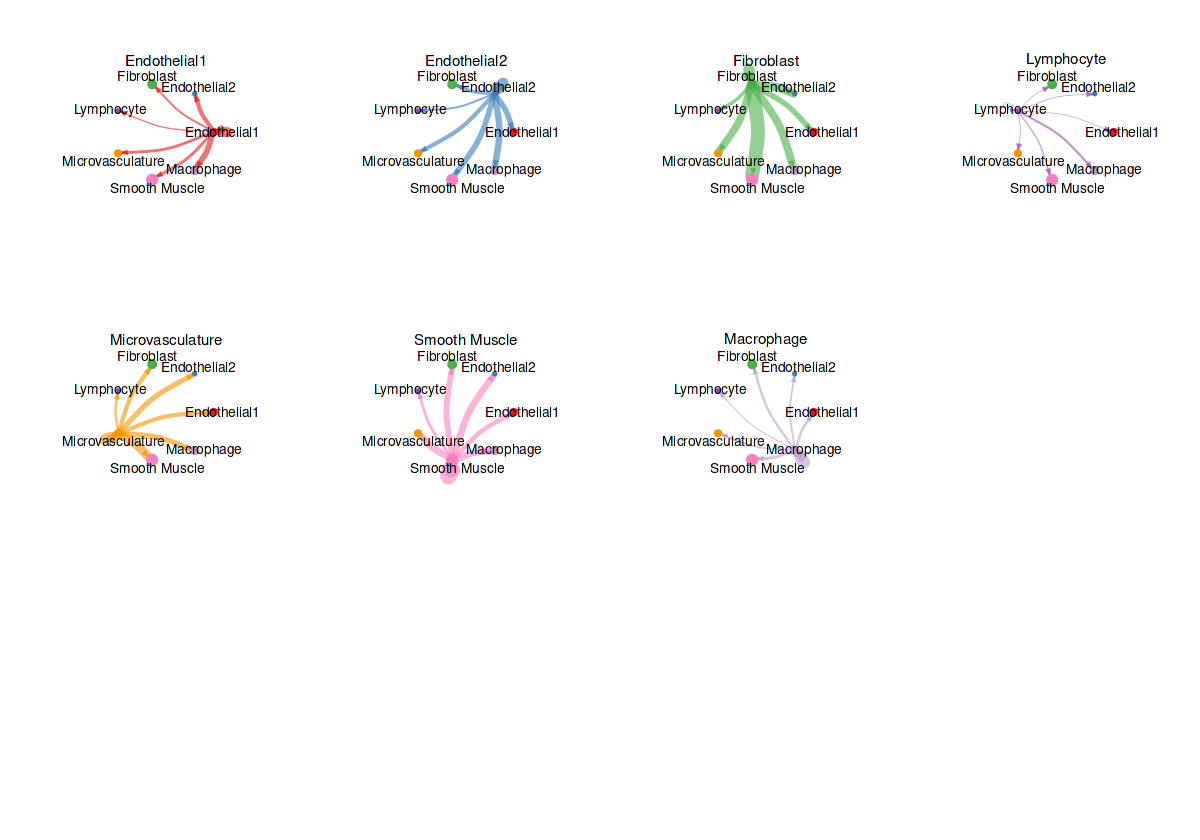

In [23]:
mat <- cellchat@net$weight
options(repr.plot.width=10, repr.plot.height=7)
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

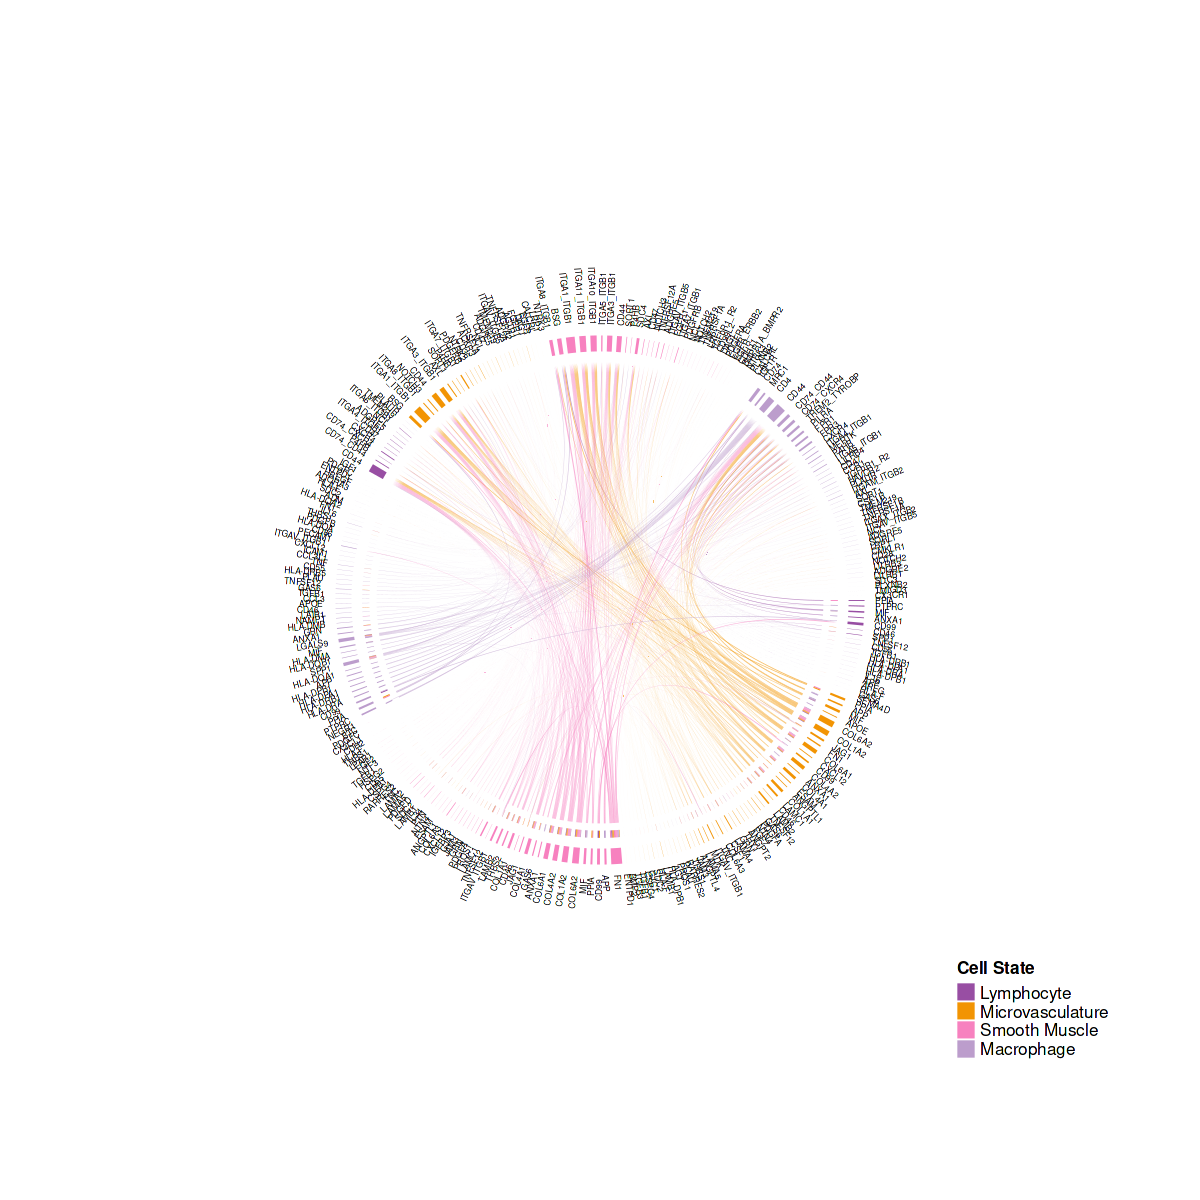

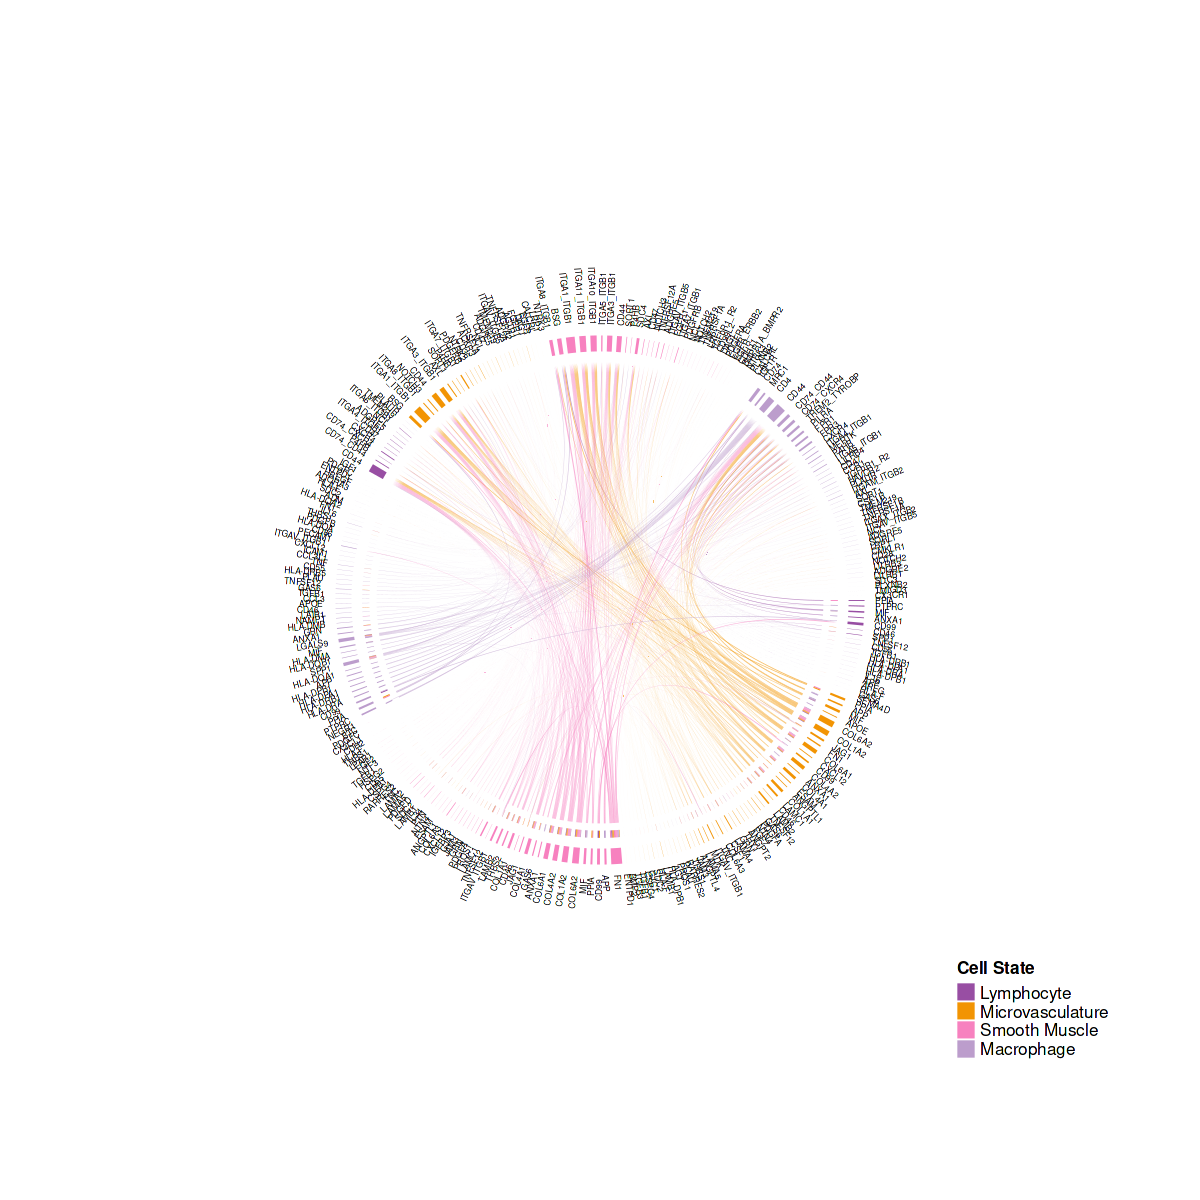

In [26]:
options(repr.plot.width=10, repr.plot.height=10)
netVisual_chord_gene(cellchat, sources.use = c(4,5,6,7), targets.use =  c(4,5,6,7), lab.cex = 0.4,legend.pos.y = 30)

In [27]:
pathways.show.all <- cellchat@netP$pathways

In [28]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP") # the slot 'netP' means the inferred intercellular communication network of signaling pathways

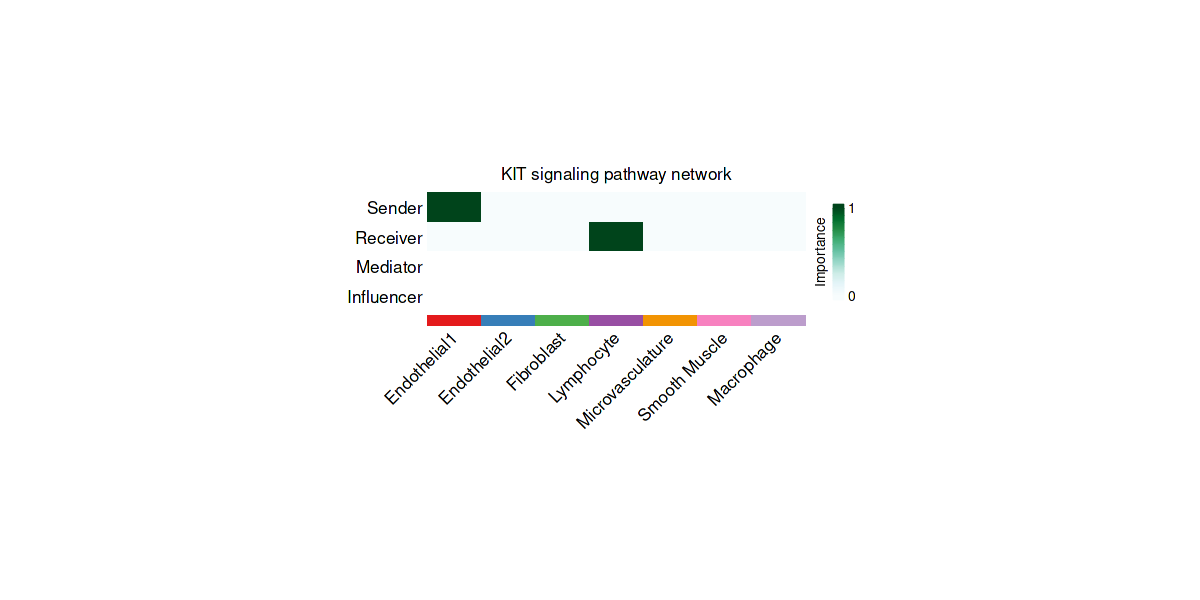

In [29]:
# Visualize the computed centrality scores using heatmap, allowing ready identification of major signaling roles of cell groups
options(repr.plot.width=10, repr.plot.height=5)
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show.all, width = 8, height = 2.5, font.size = 10)

Signaling role analysis on the cell-cell communication network from user's input



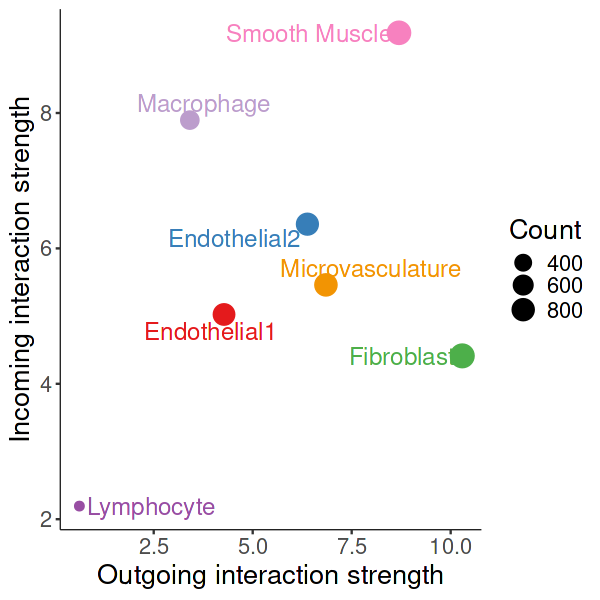

In [34]:
# Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
#gg1 <- netAnalysis_signalingRole_scatter(cellchat)
#> Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
# Signaling role analysis on the cell-cell communication networks of interest
gg2 <- netAnalysis_signalingRole_scatter(cellchat, signaling =pathways.show.all,font.size = 16,label.size = 5)
#> Signaling role analysis on the cell-cell communication network from user's input
options(repr.plot.width=5, repr.plot.height=5)
gg2

In [31]:
pathways.show.all

[1] "COLLAGEN"   "FN1"        "LAMININ"    "APP"        "CD99"      
 [6] "CypA"       "MIF"        "MHC-II"     "PECAM1"     "THBS"      
[11] "JAM"        "MK"         "ANNEXIN"    "GALECTIN"   "SPP1"      
[16] "GAS"        "IGFBP"      "CXCL"       "VISFATIN"   "CD46"      
[21] "ESAM"       "ANGPTL"     "NOTCH"      "GAP"        "VEGF"      
[26] "ADGRE"      "ADGRG"      "CD34"       "GRN"        "PDGF"      
[31] "CCL"        "FGF"        "CD45"       "COMPLEMENT" "PROS"      
[36] "TENASCIN"   "PTN"        "ANGPT"      "HSPG"       "CDH5"      
[41] "TWEAK"      "ICAM"       "ApoE"       "TGFb"       "PERIOSTIN" 
[46] "SELL"       "TNF"        "EDN"        "THY1"       "EPHB"      
[51] "BMP"        "PTPRM"      "SEMA3"      "Netrin"     "MPZ"       
[56] "CSF"        "ADGRA"      "PLAU"       "EPHA"       "LAIR1"     
[61] "CALCR"      "SEMA6"      "MHC-I"      "CSPG4"      "SEMA7"     
[66] "NRG"        "CHEMERIN"   "EGF"        "SELPLG"     "CD39"      
[71] "TRAIL"      "VCAM"       "NCAM"       "IL16"       "IGF"       
[76] "HGF"        "NEGR"       "CD86"       "AGT"        "NECTIN"    
[81] "NT"         "FLRT"       "ADGRL"      "AGRN"       "SEMA4"     
[86] "CX3C"       "CDH"        "CLDN"       "KIT"

In [35]:
saveRDS(cellchat, 'RDS/cellchat_RNA.rds')